# Step 1-1 refine the centers of disks by oval fitting

### Import the libraies

In [1]:
import cv2
import math
import imutils
import argparse 
import numpy as np
import hyperspy.api as hs
from skimage import measure
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import hsv_to_rgb
from scipy.spatial import distance_matrix
from mpl_toolkits.axes_grid1 import AxesGrid

### Step 1-1.1 Get the outlines of Bragg disks

Text(0.5, 1.0, 'CBED')

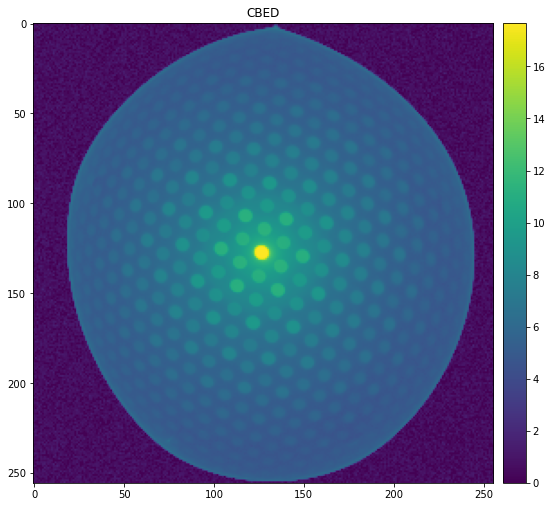

In [2]:
#load the pacbed pattern
folder = "E:/Nion_PL_aberr_20231023/5_15/"
gray = np.load(folder + "pacbed.npy")
gray = np.log(gray*10000+1)
fig =plt.figure(1, figsize=(30, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(gray, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("CBED")

Text(0.5, 1.0, 'grad')

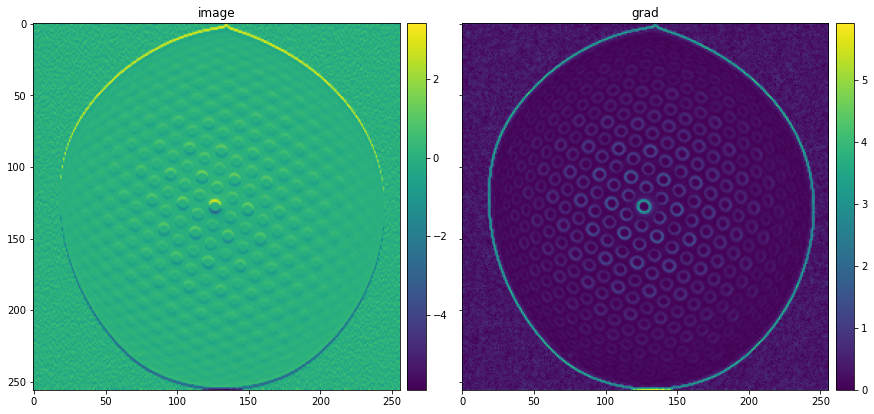

In [3]:
# get the outline of disks
img_gradx, img_grady = np.gradient(gray)
img_grad = np.sqrt(np.square(img_gradx)+np.square(img_grady))
#img_grad = np.array(img_grad, dtype = np.float32)
#img_grad = gray
fig =plt.figure(1, figsize=(50, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im1=grid[0].imshow(img_gradx, cmap=plt.cm.viridis)
im2=grid[1].imshow(img_grad, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im1)
grid.cbar_axes[1].colorbar(im2)
grid[0].set_title("image")
grid[1].set_title("grad")

In [4]:
#remove the outline of pattern
center_mask = np.zeros(gray.shape)
Y, X = np.indices(gray.shape)
x_center = gray.shape[0]/2
y_center = gray.shape[1]/2
radius_cm =gray.shape[0]*0.3  #radius of center mask to project the central disks
center_mask[np.where(np.sqrt((X-x_center)**2 + (Y-y_center)**2)>radius_cm)] = 1.0
gray_masked = img_grad*center_mask
out_thresh = gray.max()*0.07 #threshhold of the remianed singal value 
img_grad[np.where(gray_masked>out_thresh)] = 0

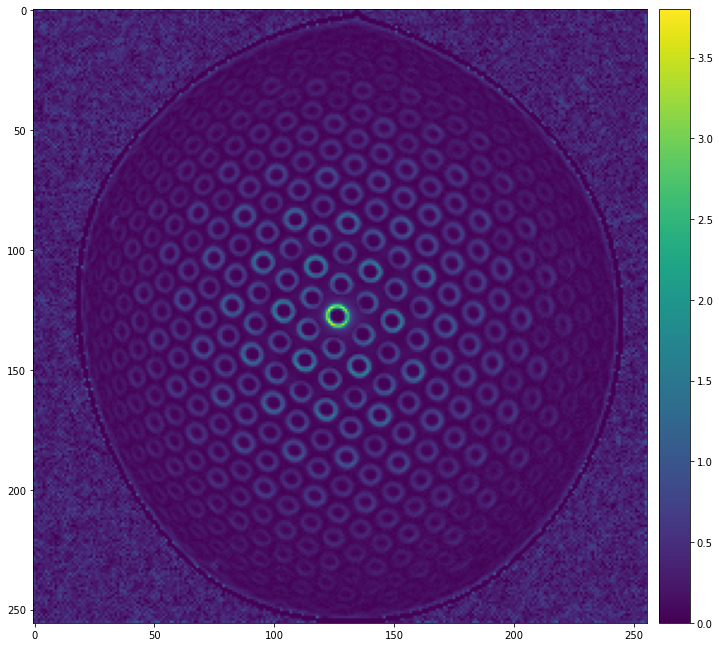

In [5]:
# remove the outline of pattern
fig =plt.figure(1, figsize=(40, 40))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(img_grad, cmap=plt.cm.viridis) 
grid.cbar_axes[0].colorbar(im)

### Step1-1.2 Fit the bragg disks as ovals

In [6]:
# load the centers obtained form Step 1
centers = np.load(folder+'BJ_515_centers_1.npy')
peak_pos = np.zeros(centers .shape)
peak_pos[:,0] = centers [:,1]
peak_pos[:,1] = centers [:,0] 

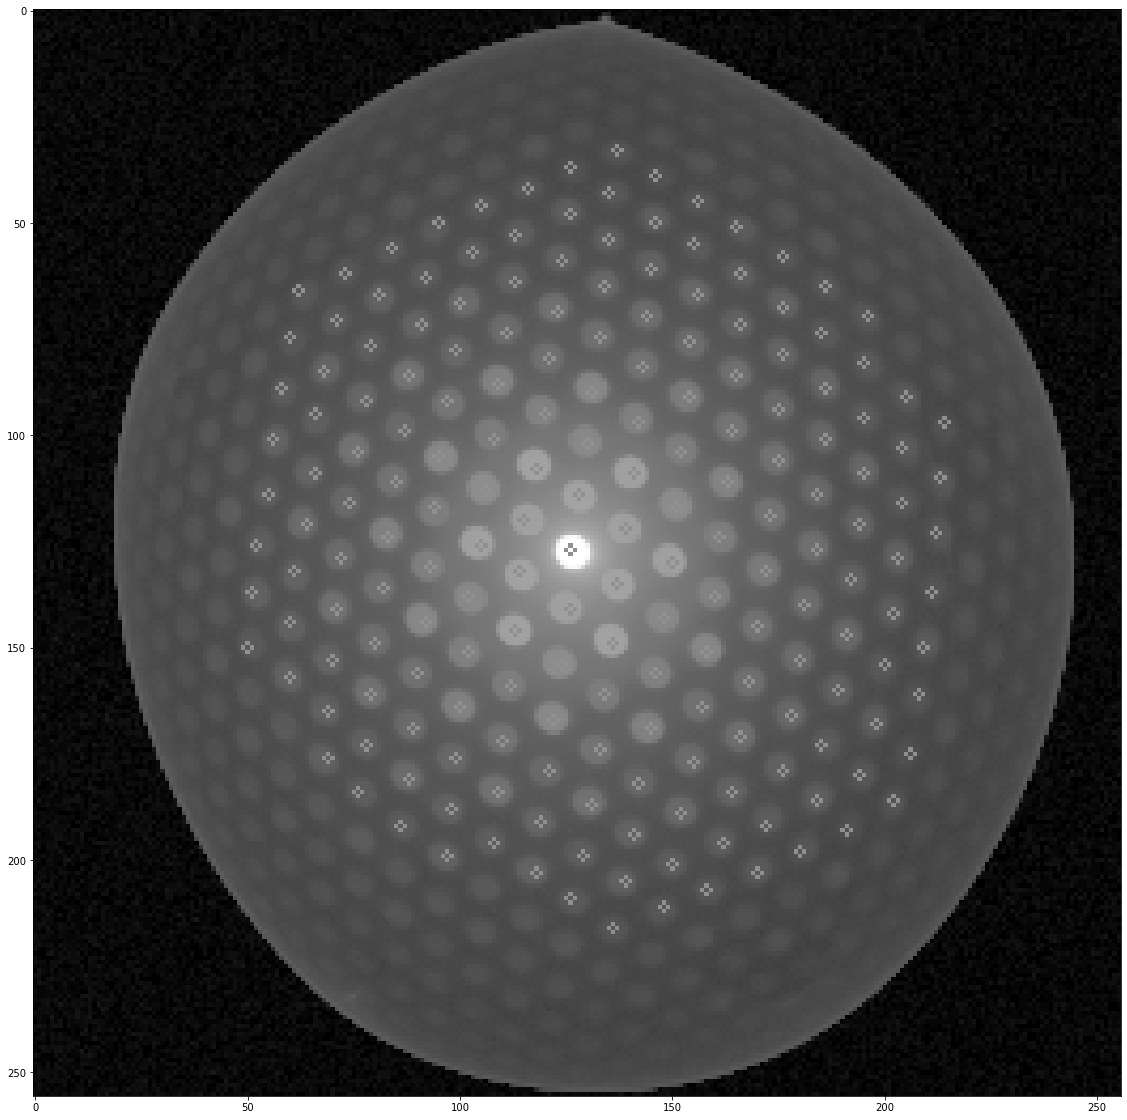

In [7]:
# plot the centers on image
rgb_frame=gray.copy()
for i in range(0, peak_pos.shape[0]):
    cv2.circle(rgb_frame,(int(np.round(peak_pos[i, 1])),int(np.round(peak_pos[i, 0]))),1,(10,0,0))
plt.figure(figsize=(20,20))
plt.imshow(rgb_frame, cmap=plt.cm.gray)

In [8]:
# Functions for fit each bragg disk into oval
def GeneOvalMask(params, grad, gridY, gridX):
    x_center = params[0]
    y_center = params[1]
    radius = params[2]
    gama = params[3]
    angle = params[4]
    gradX_temp = (gridX - x_center)*np.cos(angle) - (gridY - y_center)*np.sin(angle)
    gradY_temp = (gridX - x_center)*np.sin(angle) + (gridY - y_center)*np.cos(angle)
    radius_map = np.sqrt(gradX_temp**2 + (gama*gradY_temp)**2)
    oval_mask = np.zeros_like(grad)
    oval_mask[np.where((radius_map<=radius))] = 1.0
    return oval_mask
def OvalTarget(params, grad, gridY, gridX):
    oval_mask = GeneOvalMask(params, grad, gridY, gridX)
    oval_mask=np.sqrt(np.sum(np.square(np.abs(np.gradient(oval_mask))), axis =0))
    #generate a 2D frame for this center.
    masked_grad = grad.copy()
    masked_grad[np.where(oval_mask > 0.1)] = 0.0
    #return the total error.
    return np.sum(masked_grad)

def OvalRingMask(params, grad, gridY, gridX):
    x_center = params[0]
    y_center = params[1]
    radius = params[2]
    gama = params[3]
    angle = params[4]
    gradX_temp = (gridX - x_center)*np.cos(angle) - (gridY - y_center)*np.sin(angle)
    gradY_temp = (gridX - x_center)*np.sin(angle) + (gridY - y_center)*np.cos(angle)
    radius_map = np.sqrt(gradX_temp**2 + (gama*gradY_temp)**2)
    oval_mask = np.zeros_like(grad)
    oval_mask[np.where((radius_map<=1.1*radius)&(radius_map>0.9*radius))] = 1.0   
    return oval_mask
def OvalTarget1(params, grad, gridY, gridX):
    oval_mask = OvalRingMask(params, grad, gridY, gridX)
    masked_grad = grad.copy()
    masked_grad[np.where(oval_mask == 1)] = 0.0
    #return the total error.
    return np.sum(masked_grad)

In [9]:
# Fucntions to fit all the bragg disks
def GetOvalParamsDirect(gray1,centers,radius):
    Y, X = np.indices(img_grad.shape)
    oval_params = np.zeros((centers.shape[0], 5))
    angles = np.zeros(centers.shape[0])
    
    for i in range(centers.shape[0]):
        #img_slice = img_grad.copy()
        #img_slice[(Y<(centers[i,0]-slice_l))|(Y>(centers[i,0]+slice_l))|(X<(centers[i,1]-slice_w))|(X>(centers[i,1]+slice_w))] = 0

        if (centers[i,0]-cell0[0])*(centers[i,1]-cell0[1]) > 0:
            anglen = np.pi/2-math.atan((centers[i,0]-cell0[0])/(centers[i,1]-cell0[1]))
        elif (centers[i,0]-cell0[0])*(centers[i,1]-cell0[1]) < 0:   
            anglen = -math.atan((centers[i,0]-cell0[0])/(centers[i,1]-cell0[1]))-np.pi/2           
        else:
            anglen = 0
        
        #params = np.asarray([centers[i,1],centers[i,0], radius, 0.9, anglen])
        params = np.asarray([centers[i,1],centers[i,0], radius, 1, 0])
        new_params = optimize.minimize(OvalTarget1, params, args=(img_grad , Y, X), method='Nelder-Mead').x
        
        angles[i] = anglen
        oval_params[i] = new_params
        
    return oval_params,angles

In [10]:
# Find the central disk on the image
dist_mat = distance_matrix(peak_pos,[[img_grad.shape[0]/2,img_grad.shape[1]/2],] )
pos_idx= np.argmin(dist_mat, axis=0)
print(pos_idx)
cell0 = peak_pos[pos_idx][0]
print(cell0)

[63]
[127.4017705  125.91699472]


In [11]:
# Get the five parameters of oval for each disk
Y, X = np.indices(img_grad.shape)
centers = peak_pos
oval_radius = 3.5 # The length of short axis of oval. Adjust it into a suitable value to get a better result 
oval_params_direct,angles = GetOvalParamsDirect(img_grad,centers,oval_radius)
oval_params = oval_params_direct

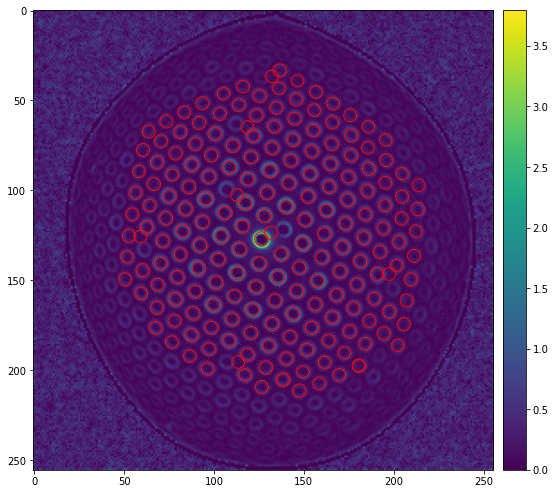

In [12]:
# Plot the ovals on the image
fig =plt.figure(1, figsize=(30, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(img_grad, cmap=plt.cm.viridis)
for i in range(centers.shape[0]):
    x_center = oval_params_direct[i,0]
    y_center = oval_params_direct[i,1] 
    radius = oval_params_direct[i,2]
    oval = patches.Ellipse((x_center, y_center), 2*radius, 2*radius/ oval_params_direct[i,3],- oval_params_direct[i,4]/np.pi*180, fill = False, color="red", linewidth=1)
    grid[0].add_patch(oval)
    
grid.cbar_axes[0].colorbar(im)

### Step 1-1.3 Refine the positions manually

In [13]:
points = np.zeros((oval_params.shape[0],2))
points[:,0] = oval_params[:,0]
points[:,1] = oval_params[:,1]

In [14]:
#import libaries for GUI
%matplotlib notebook
from ipywidgets import widgets
from scipy.spatial import KDTree

<IPython.core.display.Javascript object>


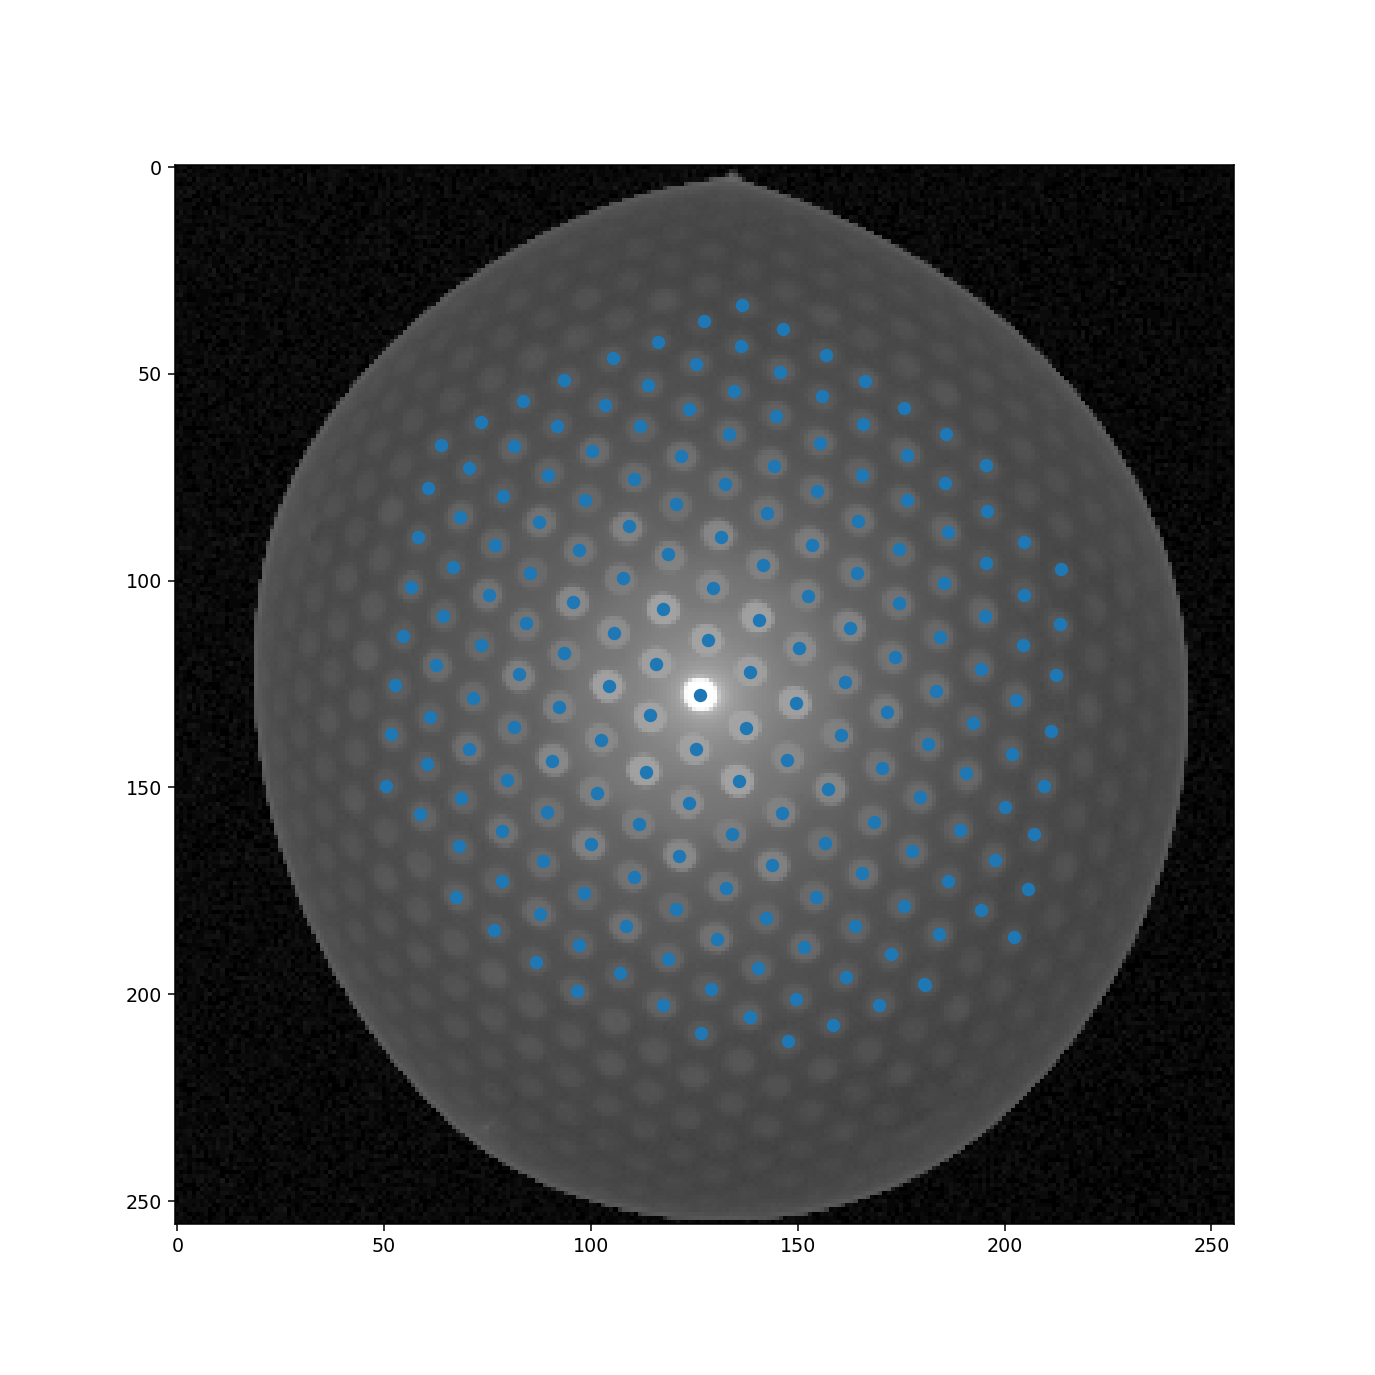

In [15]:
# plot the postions on the image and change the positon of disks
fig, ax = plt.subplots(figsize=(10, 10))
scat = ax.scatter(points[:, 0], points[:, 1])
plt.imshow(gray,cmap=plt.cm.gray )  # Replace with your image

def onclick(event):
    global points
    if event.inaxes is not ax:
        return

    # Check distance to all points
    distances = np.sqrt((points[:, 0] - event.xdata)**2 + (points[:, 1] - event.ydata)**2)
    index = np.argmin(distances)

    # Left click (button == 1) with Shift key to add a point
    if event.button == 1 and event.key == 'shift':
        print(f"Adding point at: ({event.xdata}, {event.ydata})")
        points = np.vstack([points, [event.xdata, event.ydata]])
    # Left click (button == 1) to modify the position if close enough
    elif distances[index] < 20 and event.button == 1:
        print(f"Moving point index: {index}")
        points[index] = [event.xdata, event.ydata]
    # Right click (button == 3) to delete if close enough
    elif distances[index] < 20 and event.button == 3:
        print(f"Deleting point index: {index}")
        points = np.delete(points, index, axis=0)

    scat.set_offsets(points)
    fig.canvas.draw_idle()

fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [27]:
np.save(folder +'BJ_515_centers_4.npy',points)